# A/B Hypothesis Testing: Ad campaign performance

### Table Of Contents
- [Data Exploration](#DATA-EXPLORATION-ANALYSIS)
- [Classic Testing](#Classic-Testing)
    - [Metrics](#Metrics)
        - [Invariant Metrics](#Invariant-Metrics)
        - [Evaluation Metrics](#Evaluation-Metrics)
    - [Sanity Check](#Sanity-Check)
- [Sequential Testing](#Sequential-Testing)
    - [Common sequential testing algorithms](#Common-sequential-testing-algorithms)
    - [Sequential probability ratio testing (SPRT)](#Sequential-probability-ratio-testing-(SPRT))
- [A/B testing with Machine Learning](#A/B-testing-with-Machine-Learning)
    - [Data Analysis for ML](#Data-Analysis-for-ML)
    - [Model Design](#Model-Design)

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


In [2]:
df = pd.read_csv('ABAdRecall.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [3]:
df.shape

(8077, 9)

In [4]:
# Sort the dataframe using the date column 
df = df.sort_values(by='date')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
4038,818f37f3-dae8-4a33-a22e-e54056e0ba7d,control,2020-07-03,15,Samsung SM-A600FN,6,Chrome Mobile WebView,0,0
3345,6be2edc7-cf48-4831-8edf-3694eb241e09,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
3348,6bfed6f0-66e1-4cf8-9871-ff948b5a2afe,exposed,2020-07-03,11,Generic Smartphone,6,Chrome Mobile,0,0
3354,6c3987e1-42ab-4bca-b1c9-3c6e4446f7eb,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
3356,6c3cd274-3fba-4a35-97c8-85af0385517a,exposed,2020-07-03,8,Generic Smartphone,6,Chrome Mobile,0,0


## DATA EXPLORATION ANALYSIS

([<matplotlib.patches.Wedge at 0x1f9abd37c18>,
 [Text(-0.013904850922250443, 1.0999121124530042, 'exposed'),
  Text(0.013904953903454092, -1.0999121111511334, 'control')])

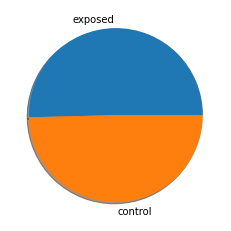

In [5]:
# a pie plot to show if the data is evenly split
plt.pie(df['experiment'].value_counts(), labels=['exposed', 'control'],shadow=True)

The above plot shows that the data is equally split between the expose and control groups 

In [6]:
# The number of users using each browser
df.browser.value_counts()

Chrome Mobile                 4554
Chrome Mobile WebView         1489
Samsung Internet               824
Facebook                       764
Mobile Safari                  337
Chrome Mobile iOS               51
Mobile Safari UI/WKWebView      44
Pinterest                        3
Chrome                           3
Opera Mobile                     3
Edge Mobile                      1
Puffin                           1
Android                          1
Opera Mini                       1
Firefox Mobile                   1
Name: browser, dtype: int64

[Text(0, 0, 'Chrome Mobile WebView'),
 Text(0, 0, 'Chrome Mobile'),
 Text(0, 0, 'Samsung Internet'),
 Text(0, 0, 'Facebook'),
 Text(0, 0, 'Mobile Safari'),
 Text(0, 0, 'Mobile Safari UI/WKWebView'),
 Text(0, 0, 'Chrome Mobile iOS'),
 Text(0, 0, 'Pinterest'),
 Text(0, 0, 'Opera Mini'),
 Text(0, 0, 'Android'),
 Text(0, 0, 'Edge Mobile'),
 Text(0, 0, 'Chrome'),
 Text(0, 0, 'Opera Mobile'),
 Text(0, 0, 'Firefox Mobile'),
 Text(0, 0, 'Puffin')]

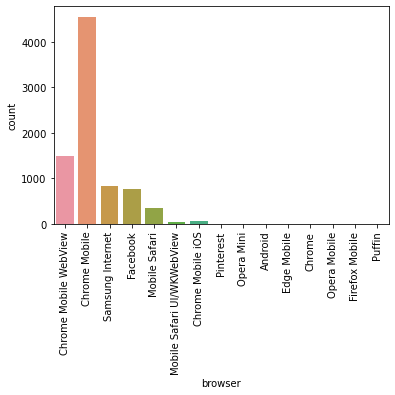

In [7]:
# Countplot for browsers
broChart = sns.countplot(x='browser', data=df)
broChart.set_xticklabels(broChart.get_xticklabels(), rotation=90) 


From the above two cells we see how many users what browser when accessing the website

In [8]:
# show the number of each os platform
df.platform_os.value_counts()

6    7648
5     428
7       1
Name: platform_os, dtype: int64

[Text(0, 0, '5'), Text(0, 0, '6'), Text(0, 0, '7')]

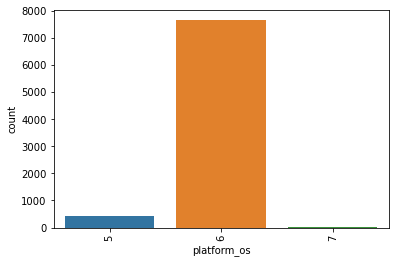

In [9]:
# Countplot for browsers
osChart = sns.countplot(x='platform_os', data=df)
osChart.set_xticklabels(osChart.get_xticklabels(), rotation=90) 

The graph above shows the os distribution its unevenly distributed

In [10]:
# number of devices in the device_make 
df.device_make.value_counts()

Generic Smartphone    4743
iPhone                 433
Samsung SM-G960F       203
Samsung SM-G973F       154
Samsung SM-G950F       148
                      ... 
Samsung SM-C9000         1
K7                       1
Samsung SM-A415F         1
X13                      1
Samsung SM-G955U         1
Name: device_make, Length: 270, dtype: int64

[Text(0, 0, 'Generic Smartphone'),
 Text(0, 0, 'iPhone'),
 Text(0, 0, 'Samsung SM-G960F'),
 Text(0, 0, 'Samsung SM-G973F'),
 Text(0, 0, 'Samsung SM-G950F'),
 Text(0, 0, 'Samsung SM-G930F'),
 Text(0, 0, 'Samsung SM-G975F'),
 Text(0, 0, 'Samsung SM-A202F'),
 Text(0, 0, 'Samsung SM-A405FN'),
 Text(0, 0, 'Samsung SM-J330FN')]

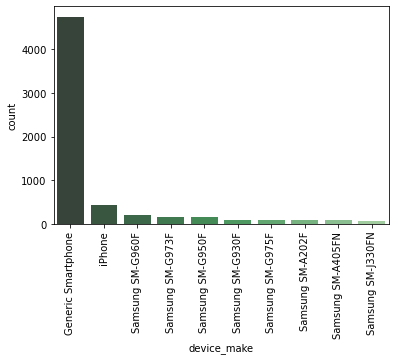

In [11]:
# countplot for the devices in device_make
devChart = sns.countplot(x='device_make',palette="Greens_d", data=df,
              order=df.device_make.value_counts().iloc[0:10].index)
devChart.set_xticklabels(devChart.get_xticklabels(), rotation=90)

The above graph shows the number of devices for the top 10 device makes

[Text(0, 0, '2020-07-03'),
 Text(0, 0, '2020-07-04'),
 Text(0, 0, '2020-07-05'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-07'),
 Text(0, 0, '2020-07-08'),
 Text(0, 0, '2020-07-09'),
 Text(0, 0, '2020-07-10')]

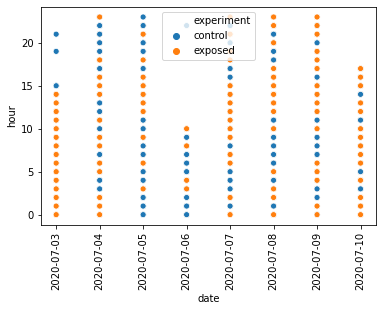

In [12]:
# scatterplot for time vs date
hourChart = sns.scatterplot(x='date', y='hour', hue='experiment', data=df)
hourChart.set_xticklabels([date for date in df.date.unique()], rotation=90)

The above graph shows date and what time the users from the two groups answered the questionare

[Text(0, 0, '2020-07-03'),
 Text(0, 0, '2020-07-04'),
 Text(0, 0, '2020-07-05'),
 Text(0, 0, '2020-07-06'),
 Text(0, 0, '2020-07-07'),
 Text(0, 0, '2020-07-08'),
 Text(0, 0, '2020-07-09'),
 Text(0, 0, '2020-07-10')]

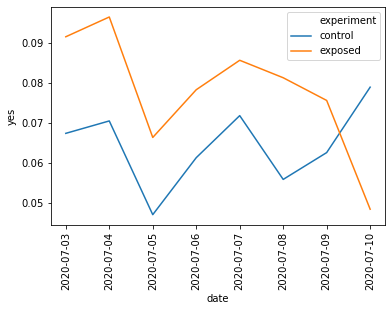

In [13]:
yesChart = sns.lineplot(x='date', y='yes', hue='experiment', ci=None, data=df)
yesChart.set_xticklabels([date for date in df.date.unique()], rotation=90)

## Classic Testing

The null hypothesis is that there is a variation of the number of users who know the brand due to the ads and the alternate hypothesis is that there no difference between the exposed and control groups in terms of brand awareness.

> $H_0$ : There is an improvement in brand awareness as a result of the ads

> $H_1$ : There is no improvement in brand awareness as a result of the ads

The choosen value for the significance level was 0.05.
>($\alpha$ = 0.05)

### Metrics
### Invariant Metrics 
Invariate metrics are used for "sanity checks", that is, to make sure our experiment (the way we presented a change to a part of the population, as well as the way we collected the data) is not inherently wrong. This means we pick metrics which we consider not to change (not to be affected) because of our experiment and later make sure these metrics don't change drastically between our control and experiment groups.

> What operating system users' have.

### Evaluation Metrics
Evaluation metrics on the other hand, are the metrics in which we expect to see a change, and are relevant to the business goals we aim to achieve.

> $Control_{conversion}$ = $\frac{control_{yes}}{control_{total}}$

> $Exposed_{conversion}$ = $\frac{exposed_{yes}}{exposed_{total}}$

In [14]:
# Find the data for the invariant people the people
# who didn't click the radio button
dfInva= df[df['yes'] == df['no'] ]
print(dfInva.shape)

# confirm there is only one unique values in both the yes and no cols
print(dfInva.yes.unique())
print(dfInva.no.unique())
dfInva

(6834, 9)
[0]
[0]


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
4038,818f37f3-dae8-4a33-a22e-e54056e0ba7d,control,2020-07-03,15,Samsung SM-A600FN,6,Chrome Mobile WebView,0,0
3345,6be2edc7-cf48-4831-8edf-3694eb241e09,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
3348,6bfed6f0-66e1-4cf8-9871-ff948b5a2afe,exposed,2020-07-03,11,Generic Smartphone,6,Chrome Mobile,0,0
3354,6c3987e1-42ab-4bca-b1c9-3c6e4446f7eb,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
3356,6c3cd274-3fba-4a35-97c8-85af0385517a,exposed,2020-07-03,8,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
4803,992da556-bd05-401f-a257-d105c7a956a5,exposed,2020-07-10,0,Generic Smartphone,6,Chrome Mobile,0,0
4786,989c096c-cac0-4aa5-a799-dc63b48107a1,exposed,2020-07-10,8,Samsung SM-A105FN,6,Samsung Internet,0,0
4764,9812db3b-2c00-472d-8d30-a0b06c813357,exposed,2020-07-10,15,Samsung SM-G960F,6,Chrome Mobile WebView,0,0
4736,97041ed0-0eb3-4306-9ce2-58b24a2226b0,exposed,2020-07-10,16,Samsung SM-G920F,6,Samsung Internet,0,0


In [15]:
# Get the number of users who click the radio button (viable for evaluation)
dfEva = df[df['yes'] != df['no']]
print(dfEva.shape)

# confirm there are two unique values in both the yes and noo cols
print(dfEva.yes.unique())
print(dfEva.no.unique())
dfEva

(1243, 9)
[0 1]
[1 0]


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
7703,f3fb35f0-a937-4db9-a853-5be0af307d41,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1
3390,6d7bc840-4247-4d7c-b135-81a2ce9d2a27,control,2020-07-03,15,MAR-LX1A,6,Facebook,0,1
3286,6a3e319e-5c3e-488f-a158-b075cb5f6591,exposed,2020-07-03,11,Generic Smartphone,6,Chrome Mobile,0,1
3289,6a59d23a-38dd-41ab-a29a-64d590d1975e,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
3290,6a5bd09d-b9f8-4e77-a4e1-4e781929414a,control,2020-07-03,15,MRD-LX1,6,Facebook,1,0
...,...,...,...,...,...,...,...,...,...
4727,969b46ce-480b-476f-88ee-4f4c1d909597,control,2020-07-10,15,Samsung SM-G960F,6,Facebook,1,0
4881,9b7a2497-f2f3-4cfd-bf1b-bf533fa39f4f,exposed,2020-07-10,2,Generic Smartphone,6,Chrome Mobile,0,1
4863,9b0b9843-4898-4d85-a3ad-9d4004cb4bcc,control,2020-07-10,8,Samsung SM-G930F,6,Chrome Mobile WebView,1,0
4735,96ee2c29-9680-4621-b14c-0c66ec0988e2,control,2020-07-10,7,Generic Smartphone,6,Chrome Mobile WebView,0,1


In [16]:
# Check if the number of users in the exposed group
# is equal to the number of users in the controll group
df['experiment'].value_counts()

control    4071
exposed    4006
Name: experiment, dtype: int64

In [17]:
# Check if the number of users in the exposed group
# is equal to the number of users in the controll group
dfEva['experiment'].value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

In [18]:
# Get the exposed group and find the yes values
dfExp = dfEva[dfEva['experiment']== 'exposed']
dfExp.yes.value_counts()

0    349
1    308
Name: yes, dtype: int64

In [19]:
# Get the control group and find the values they have for yes
dfCon = dfEva[dfEva['experiment']== 'control']
dfCon.yes.value_counts()

0    322
1    264
Name: yes, dtype: int64

In [20]:
# calculating the conversion rates for 
exposed, control = 657, 586
expYes, conYes = 308, 264
expEr, conEr = float(expYes)/float(exposed), float(conYes)/ float(control)
print(expEr)
print(conEr)

0.4687975646879756
0.45051194539249145


In [21]:
# minimum detecctable effect
dHat = expEr - conEr
dHat

0.018285619295484168

In [22]:
# calculating the standard error for the entire group
pHat = (expYes + conYes) / (exposed + control)
stdErr = np.sqrt(pHat * (1 - pHat) * (1 / exposed + 1 / control ))
stdErr

0.028319932727228023

In [23]:
# Calculating the standard error for each group
expStd = np.sqrt(expEr * (1 - expEr) / exposed)
conStd = np.sqrt(conEr * (1 - conEr) / exposed)

# Calculating the zScore
zScore = (expEr - conEr) / np.sqrt(expStd**2 + conStd**2)
zScore

0.6651183185408868

In [24]:
# Find out how significat the test is
pVal = dHat - zScore * stdErr
pVal

-0.000550486741240766

The pValue calculated is less than the significance level defined in the beginning so we reject the null hypothesis. i.e
> The ad shown has no effect on the brand awareness

## Sanity Check

In [80]:
# Check how the os is distributed in the exposed dataframe 
dfExp.platform_os.value_counts()

6    653
5      4
Name: platform_os, dtype: int64

In [84]:
# Check how the os is distributed in the control dataframe 
dfCon.platform_os.value_counts()

6    573
5     13
Name: platform_os, dtype: int64

In [86]:
# The numbers of users with platform_os 6 in two groups
expOs6 = 653
conOs6 = 573

# Total number of users on os 6
totalOs6 = expOs6 + conOs6

#Returns: z-score for given alpha
def getZScore(alpha):
    return norm.ppf(alpha)

p=0.5
alpha=0.05
p_hat=round(conOs6 / (totalOs6), 2)
sd=np.sqrt(p*(1-p)/(totalOs6))
ME=round(getZScore(1-(alpha/2))*sd, 2)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.47 and 0.53 ; Is 0.47 inside this range?




Our observed $\hat{p}$ is inside this range which there is no difference in number of os usage between groups. So far so good, since this invariant metric sanity test passes!

## Sequential Testing
A common issue with classical A/B-tests, especially when you want to be able to detect small differences, is that the sample size needed can be prohibitively large. In many cases it can take several weeks, months or even years to collect enough data to conclude a test. 

*   The lower number of errors we require, the larger sample size we need.
* The smaller the difference we want to detect, the larger sample size is required.

Sequential sampling works in a very non-traditional way; instead of a fixed sample size, you choose one item (or a few) at a time, and then test your hypothesis. You can either:

* Reject the null hypothesis (H0) in favor of the alternate hypothesis (H1) and stop,
* Keep the null hypothesis and stop,
* unable to reach either conclusion with current observation and continue sampling.

### Advantage of Sequential testing over classic a/b testing


*   optimize necessary observation (sample size)
*   reduce the likelihood of error
* gives a chance to finish experiments earlier without increasing the possibility of false results

**N.B: Unlike classical fixed sample-size tests, where significance is only checked after all samples have been collected, this test will continously check for significance at every new sample and stop the test as soon as a significant result is detected, while still guaranteeing the same type-1 and type-2 errors as the fixed-samplesize test.**

## Common sequential testing algorithms
- [Evan Miller Simple Sequential A/B Testing](https://www.evanmiller.org/sequential-ab-testing.html)
- [Sequential probability ratio testing (SPRT)](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test)

The Evan Miller sequential procedure for one-sided test works as follows:
* choose a sample size \(N\). [Here](https://www.evanmiller.org/ab-testing/sequential.html) is the link to define N
* Assign subjects randomly to the treatment and control, with 50% probability each.
* Track the number of incoming successes from the treatment group. Call this number \(T\).
* Track the number of incoming successes from the control group. Call this number \(C\).
* If \(T-C\) reaches \(2\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

The two-sided test is essentially the same, but with an alternate ending:
* If \(T-C\) reaches \(2.25\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(C-T\) reaches \(2.25\sqrt{N}\), stop the test. Declare the control to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

**N.B: This test completely ignores the number of failures in each group, which makes it significantly easier to implement in low-conversion settings. However**
- **If we hit the threshold without having reached statistical proof, we cannot continue the experiment.**
- **Even if preliminary evidence says that one version is terrible, we will keep losing conversions until we hit an arbitrarly pre-agreed threshold.**

### Sequential probability ratio testing (SPRT)
SPRT is based on the likelihood ratio statistic.
#### Variants of SPRT
- [Wald's(1947) sequential probability ratio test](http://en.wikipedia.org/wiki/Sequential_probability_ratio_test)
 * Wald's test uses one pair of observations at each stage and ignores tied observations and thus reduces a test of a single proportion.
- [Conditional sequential probability ratio test](http://www.jstor.org/stable/2346379?seq=1#page_scan_tab_contents)
 * used to calculate tied observations b/n two proportions. So, determining statistical significance with two distributional streams of data can be used for conditional sprt.
- [Sequential Generalized Likelihood Ratio Test](https://www.auduno.com/2014/12/25/rapid-a-b-testing-with-sequential-analysis/)
  * used to measure tied observation. Has stoping rule estimation problem.

We focus on conditional SPRT for this challenge.

General steps of conditional SPRT

1. Set statistical parameters (alpha, beta, odd ratio)
2. Calculate critical upper and lower decision boundaries a & b

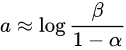    and     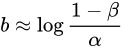
3. Then for each trail(observation) compute
 * calculate test statistics(likelihood ratio) as S
 * calculate upper and lower limits for exposed group
 * apply stopping rule


#### Stopping Rule

1. If the log probability ratio greater than or equal to the upper critical limit then the model reject the null hypothesis with the favor of alternative hypothesis (i.e. accept H1 (conclude that version two is better than version one)) and terminate the test.
  
      image.png
 
2. If the log probability ratio less than or equal to the lower critical limit then accept the null hypothesis (i.e. conclude that there is no difference between the two groups) and terminate the test.

      image.png
3. If neither critical limit is reached, conduct another trial and continue the test.

    image.png

One-sided SPRT

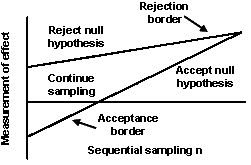

Two-sided SPRT

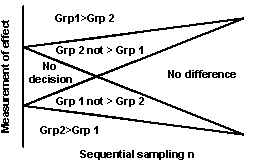

Next we will write python implementation for conditional SPRT


In [43]:
#@title
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115
def ConditionalSPRT(x,y,t1,alpha=0.05,beta=0.10,stop=None):
        if t1<=1:
            printLog('warning',"Odd ratio should exceed 1.")
        if (alpha >0.5) | (beta >0.5):
            printLog('warning',"Unrealistic values of alpha or beta were passed."
                     +" You should have good reason to use large alpha & beta values")
        if stop!=None:
            stop=math.floor(n0)        
        
        def comb(n, k):
            return factorial(n) // factorial(k) // factorial(n - k)
        
        def lchoose(b, j):
            a=[]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                if len(j)<2:
                    j=j[0]
            if (type(j) is list) | (isinstance(j,np.ndarray)==True):
                for k in j:
                    n=b
                    if (0 <= k) & (k<= n):
                        a.append(math.log(comb(n,k)))
                    else:
                        a.append(0)
            else:
                n=b
                k=j
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)

            return np.array(a)

        def g(x,r,n,t1,t0=1):
            return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

        def h(x,r,n,t=1):
            return f(r,n,t,offset=ftermlog(x,r,n,t))

        def f(r,n,t,offset=0):
            upper=max(0,r-n)
            lower=min(n,r)
            rng=list(range(upper,lower+1))
            return np.sum(fterm(rng,r,n,t,offset))

        def fterm(j,r,n,t,offset=0):
            ftlog=ftermlog(j,r,n,t,offset)
            return np.array([math.exp(ex) for ex in ftlog])

        def ftermlog(j,r,n,t,offset=0):
            xx=r-j
            lch=lchoose(n,j)
            lchdiff=lchoose(n,xx)
            lg=np.array(j)*math.log(t)
            lgsum=lch+lchdiff
            lgsum2=lgsum+lg
            lgdiff=lgsum2-offset

            return lgdiff

        def logf(r,n,t,offset=0):

            z=f(r,n,t,offset)
            if z>0:
                return math.log(z)
            else:
                return np.nan

        def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
            offset=ftermlog(math.ceil(r/2),r,n,t1c)
            z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
            a=-math.log(alpha/(1-beta))
            b=math.log(beta/(1-alpha))
            lower=b
            upper=1+a
            return (np.array([lower,upper])+z)/math.log(t1c/t0)
            
        l=math.log(beta/(1-alpha))
        u=-math.log(alpha/(1-beta))
        sample_size=min(len(x),len(y))
        n=np.array(range(1,sample_size+1))

        if stop!=None:
            n=np.array([z for z in n if z<=stop])
        x1=np.cumsum(x[n-1])
        r=x1+np.cumsum(y[n-1])
        stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g

        clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
        limits=[]
        for v in clu:
            inArray=[]
            for vin in v:
                inArray.append(math.floor(vin))
            limits.append(np.array(inArray))
        limits=np.array(limits)

        k=np.where((stats>=u) | (stats<=l))
        cvalues=stats[k]
        if cvalues.shape[0]<1:
            k= np.nan
            outcome='Unable to conclude.Needs more sample.'
        else:
            k=np.min(k)
            if stats[k]>=u:
                outcome=f'Exposed group produced a statistically significant increase.'
            else:
                outcome='Their is no statistically significant difference between two test groups'
        if (stop!=None) & (k==np.nan):
            c1=clowerUpper(r,stop,t1,alpha,beta)
            c1=math.floor(np.mean(c1)-0.5)
            if x1[n0]<=c1:
                truncate_decision='h0'
                outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
            else:
                truncate_decision='h1'
                outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
            truncated=stop
        else:
            truncate_decision='Non'
            truncated=np.nan
        return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

##### Use the next class structure to complete your sequential testing

In [95]:
## your code here. include other necessary functions as you want.
class SequentialTest:
  def __init__(self,exposed,control,alpha=0.05,beta=0.10,stop=None):
    '''
    initialise startup variables
    '''
    if t1<=1:
        printLog("warning", "odd ratio should exceed 1.")
    if (alpha > 0.5 | (beta > 0.5)):
        printLog("warning", "Unrealistic values pf alpha or beta were passed."
                + "You should have good reason to use large aplha & beta values")
    if stop != None:
        stop = math.floor(n0)
  
  def stoppingRule(self, alpha=0.05,beta=0.10):
    '''
    This function should take current observation and return statistical decision made. 
    Consider truncate rule for longer tests
    '''
    

  def computeBoundaries(self, alpha, Beta):
    '''
    This function shoud compute boundaries 
    '''
    a = math.log( beta / (1 - alpha))
    b = math.log(( 1 - beta) / alpha)
    return a, b
    
    
  def plotTest(self,):
    '''
    showing the cumulative statistical test (e.g., log probability ratio) and the uper and lower limits.
    '''

  def plotBoundaries(self,):
    '''cumulative sums of exposed successes, bounded by the critical limits.
    '''


In [76]:
def transform_data(df):
    '''
    segment data into exposed and control groups
    consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
      create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array),
    the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''

    df['dateHour'] = pd.to_datetime(df.date)
    df.dateHour += pd.to_timedelta(df.hour, unit='h')
    df.dateHour = df.dateHour.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

    grps = df.groupby('experiment')
    dfGrpControl = grps.get_group('control')
    dfGrpExposed = grps.get_group('exposed')

    dfExposed = dfGrpExposed.groupby('dateHour').agg({'auction_id':'count', 'device_make':'count', 'platform_os':'count', 'browser':'count', 'yes':'sum', 'no':'sum'})
    dfControl = dfGrpControl.groupby('dateHour').agg({'auction_id':'count', 'device_make':'count', 'platform_os':'count', 'browser':'count', 'yes':'sum', 'no':'sum'})

    dfExposed['engagement'] = dfExposed['yes'] + dfExposed['no']
    dfControl['engagement'] = dfControl['yes'] + dfControl['no'] 


    global probExp, probCon
    probExp = dfExposed.yes.sum() / dfExposed.engagement.sum()
    probCon = dfControl.yes.sum() / dfControl.engagement.sum()

    expEngArr = dfExposed['engagement'].to_numpy()
    conEngArr = dfControl['engagement'].to_numpy()

    exposed = np.random.choice([0, 1], size=((np.sum(expEngArr)),), p=[probExp, 1-probExp])
    control = np.random.choice([0, 1], size=((np.sum(conEngArr)),), p=[probCon, 1-probCon])

    return exposed,control

def plotDataSummary(exposed, control):
    'This function plots cummulated success'
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1, 1, 1)
    ax1.hist(exposed, bins=20, cumulative=True)
    ax1.set_xlabel('Yes')
    ax1.set_ylabel('Cumulative sum')
    ax1.set_title('exposed cumulative chart')

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.hist(control, bins=20, cumulative=True)
    ax2.set_xlabel('yes')
    ax2.set_ylabel('Cumulative sum')
    ax2.set_title('control cumulative chart')
    

def pretyPrintTestResult(self, test):
    '''This function print final test result. Json format is recommended. For example
    {
        "name": "",
        "engagementCountControl": ,
        "engagementCountExposed": ,
        "positiveCountControl": ,
        "positiveCountExposed": ,
        "ControlSuccessProbability": ,
        "ExposedSuccessProbability": ,
        "basePositiveRate": ,
        "significanceSign": ".",
        "lift": ,
        "oddRatio": ,
        "exactSuccessOddRate":,
        "confidenceIntervalLevel": ,
        "alpha": ,
        "beta": ,
        "power": ,
        "criticalValue": ,
        "lower critical(a)": 
        "upper critical(b)": ,
        "TotalObservation": 
  }'''

'Unable to conclude.Needs more sample.'

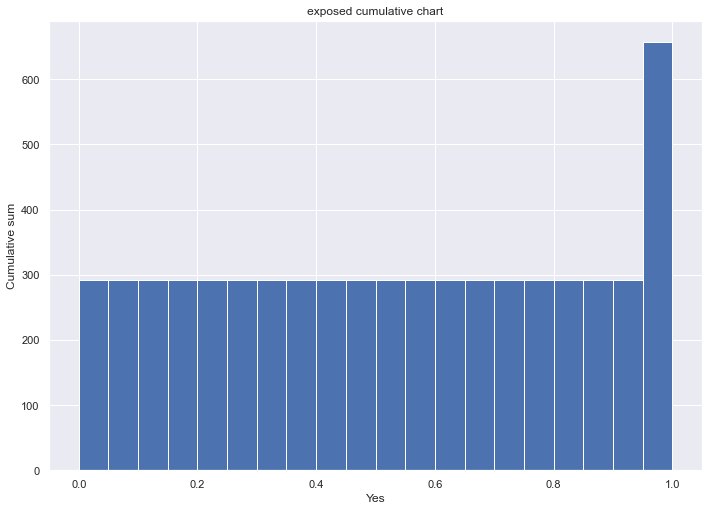

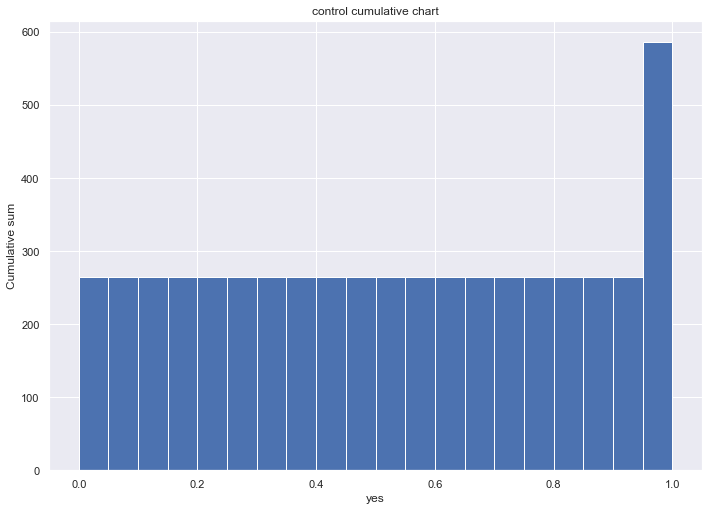

In [77]:

from math import *
import numpy as np

######################################
'Define statistical parameters such as alpha, beta, sample size if evan approach is used, odd ratio for SPRT'
alpha = 0.05
beta = 0.01
#other variables here
'Compute statistical lower and upper decision points such as a and b'
a = math.log( beta / (1 - alpha))
b = math.log(( 1 - beta) / alpha)
#other variables here

dfSe = pd.read_csv('ABAdRecall.csv')

##data processing here
exposed, control = transform_data(dfSe)
##plot data summary
plotDataSummary(exposed,control)

# Values gotten from the global variables in ConditionalSPRT
oddRatio = ( probExp / (1 - probExp )) / (probCon / (1 - probCon ))

'Perform test. Loop over each of data entry and perform test. Accumulate result into dataframe and print out test journey'
# test=SequentialTest(...)
test = ConditionalSPRT(x=exposed, y=control, t1=oddRatio)

'Print test result.'
# pretyPrintTestResult(resultObject)
test[0]

The above graph shows the cumulated data of the exposed and control arrays 

## A/B testing with Machine Learning

### Data Analysis for ML


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

dfMl = pd.read_csv('ABAdRecall.csv')
dfMl.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [58]:
# turn the browser category into a number
labelEncoder = LabelEncoder()
dfMl['browser'] = labelEncoder.fit_transform(dfMl["browser"])
browsers = labelEncoder.classes_
print(browsers)
dfMl.head()

['Android' 'Chrome' 'Chrome Mobile' 'Chrome Mobile WebView'
 'Chrome Mobile iOS' 'Edge Mobile' 'Facebook' 'Firefox Mobile'
 'Mobile Safari' 'Mobile Safari UI/WKWebView' 'Opera Mini' 'Opera Mobile'
 'Pinterest' 'Puffin' 'Samsung Internet']


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,2,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,2,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,3,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,6,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,2,0,0


In [59]:
# Turn the device_make into a number
dfMl['device_make'] = labelEncoder.fit_transform(dfMl["device_make"])
deviceMake = labelEncoder.classes_
print(len(deviceMake))
dfMl.head()

270


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,46,6,2,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,46,6,2,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,29,6,3,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,137,6,6,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,46,6,2,0,0


In [60]:
#Turn the date column into a specific number
dfMl.date = pd.to_datetime(dfMl.date)
dfMl.date = dfMl.date.dt.dayofweek
dfMl.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,4,8,46,6,2,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,1,10,46,6,2,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,6,2,29,6,3,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,4,15,137,6,6,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,4,15,46,6,2,0,0


In [61]:
#Turn experiment column into binary
dfMl['experiment'] = labelEncoder.fit_transform(dfMl["experiment"])
experiment = labelEncoder.classes_
print(len(experiment))
dfMl.head()

2


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,1,4,8,46,6,2,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,1,1,10,46,6,2,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,6,2,29,6,3,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,0,4,15,137,6,6,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,0,4,15,46,6,2,0,0


Drop the platform_os Column as its not distributed enough and auction_id as it's a unique identifier 

In [62]:
# dropping the platform_os and auction_id
dfMl.drop(['auction_id', 'platform_os'], axis=1, inplace=True)
dfMl.head()

,experiment,date,hour,device_make,browser,yes,no
0,1,4,8,46,2,0,0
1,1,1,10,46,2,0,0
2,1,6,2,29,3,0,1
3,0,4,15,137,6,0,0
4,0,4,15,46,2,0,0


In [63]:
# creating a new column that will be our target column
dfMl.loc[dfMl['no'] == 1, 'targetCol'] = 0
dfMl.loc[dfMl['yes'] == 1, 'targetCol'] = 1
dfMl.loc[dfMl['yes'] == dfMl['no'], 'targetCol'] = 2
dfMl.head()

,experiment,date,hour,device_make,browser,yes,no,targetCol
0,1,4,8,46,2,0,0,2.0
1,1,1,10,46,2,0,0,2.0
2,1,6,2,29,3,0,1,0.0
3,0,4,15,137,6,0,0,2.0
4,0,4,15,46,2,0,0,2.0


In [64]:
# droping the yes and no cols
dfMl.drop(['yes', 'no'], axis=1, inplace=True)
dfMl.head()

,experiment,date,hour,device_make,browser,targetCol
0,1,4,8,46,2,2.0
1,1,1,10,46,2,2.0
2,1,6,2,29,3,0.0
3,0,4,15,137,6,2.0
4,0,4,15,46,2,2.0


In [93]:
# creating the X(features) and Y(targetCol) dataframes
Y = dfMl['targetCol']
X = dfMl.drop(['targetCol'], axis=1)
features = X.columns
X.head()

,experiment,date,hour,device_make,browser
0,1,4,8,46,2
1,1,1,10,46,2
2,1,6,2,29,3
3,0,4,15,137,6
4,0,4,15,46,2


### Model Design

In [66]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### K-fold Cross Validation
K-Fold CV is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. Lets take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.
Image for post

In [90]:
# dividing the data set into 90% train set 10% test set
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.1, random_state=42)

# Defining the models to use 
xGradient = xgb.XGBClassifier()
logReg = LogisticRegression()
decTree = DecisionTreeClassifier()    

def modelKfold(model, x, y):
    # A list to append all the score for each fold
    scores = []
    
    # split the data further using KFold
    cv = KFold(n_splits=5,random_state=42, shuffle=True)
    for trainIndex, testIndex in cv.split(xTrain):

        cvXTrain, cvXTest = x.iloc[trainIndex], x.iloc[testIndex]
        cvYTrain, cvYTest = y.iloc[trainIndex], y.iloc[testIndex]
        
        # Train the model and predict on the test set
        modelTrained = model.fit(cvXTrain, cvYTrain)
        yPred = modelTrained.predict(x.iloc[testIndex])
        
        # find the score (score for one fold) and append them to the scores list(all the scores)
        scores.append(round(accuracy_score(cvYTest, yPred), 2))
        
    return modelTrained, scores

xGradientTrained, xgScores = modelKfold(xGradient, xTrain, yTrain)
logRegTrained, lrScores= modelKfold(logReg, xTrain, yTrain)
decTreeTrained, dtScores= modelKfold(decTree, xTrain, yTrain)

print("The scores for xgboost are: ")
print('\n'.join('{}: {}'.format(*k) for k in enumerate(xgScores)))
print("\n\n The scores for Logistic regression are: ")
print('\n'.join('{}: {}'.format(*k) for k in enumerate(lrScores)))
print("\n\n The scores for Decision Tree are: ")
print('\n'.join('{}: {}'.format(*k) for k in enumerate(dtScores)))

c:\users\gkkar\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\gkkar\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

The scores for xgboost are: 
0: 0.83
1: 0.84
2: 0.84
3: 0.84
4: 0.83


 The scores for Logistic regression are: 
0: 0.83
1: 0.85
2: 0.86
3: 0.85
4: 0.84


 The scores for Decision Tree are: 
0: 0.77
1: 0.77
2: 0.79
3: 0.79
4: 0.78


In [91]:
# logistic regression has the best values
lrPred = logRegTrained.predict(xTest)
print("The prediction on the test is: ", round(accuracy_score(yTest, lrPred), 2))

The prediction on the test is:  0.85


Feature: 0, Score: -0.17089
Feature: 1, Score: -0.02100
Feature: 2, Score: -0.01313
Feature: 3, Score: -0.00099
Feature: 4, Score: 0.01585


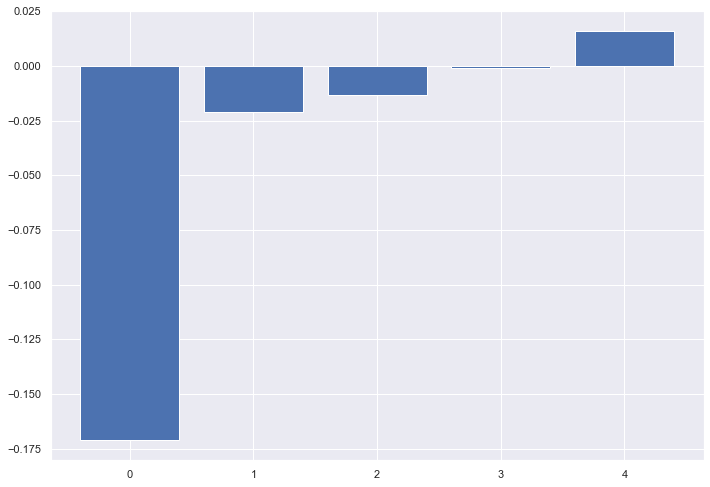

Index(['experiment', 'date', 'hour', 'device_make', 'browser'], dtype='object')

In [94]:
# get importance
importance = logRegTrained.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
features

The Above graph shows the barplot of feature importance of the different columns